# Global mean Sea Surface Temperatures

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib.dates import DateFormatter
import platform
import os

from dask.distributed import Client
from dask import delayed
import dask

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

plt.rcParams['figure.figsize'] = (10, 4)

# Settings

In [3]:
year1= 1982
year2= 2025

In [4]:
# Settings compute de climatoloy
yearC1='1982'
yearC2='1992'

# Inicio

In [5]:
HOME=os.environ['HOME']   
f = open(HOME+'/.env', 'r')
for line in f.readlines():
    Name=line.strip().split('=')[0]
    Content=line.strip().split('=')[-1]
    if Name=='dirData' or Name=='dirAnalisis':
        exec(Name + "=" + "'" + Content + "'")
f.close()

In [6]:
if os.uname().nodename.lower().find('eemmmbp') != -1:
    base_file = dirData + '/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
    dataDir   = dirAnalisis + '/SSTGlobalAnalysis/data'
elif os.uname().nodename.lower().find('sagams') != -1:
    base_file = dirData + '/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
    dataDir   = dirAnalisis + '/SSTGlobalAnalysis/data'
elif os.uname().nodename.lower().find('rossby') != -1:
    base_file = dirData + '/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
    dataDir   = dirAnalisis + '/SSTGlobalAnalysis/data'

In [7]:
base_file

'/data/pvb/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'

In [8]:
Titulos = ['Oceano Global','Hemisferio norte','Hemisferio sur',
           'Atlántico Norte','Iberian Canary Basin',
           'Demarcación marina levantino-balear', 'Demarcación marina noratlántica','Demarcación marina canaria','Demarcación sudatlántica','Demarcación Estrecho y Alborán']
Titulos_short = ['GO','NH','SH',
                 'NAtl','IBICan',
                 'LEB', 'NOR','CAN','SUD','ESA']

## Load data

In [9]:
it=4

In [10]:
titulo = Titulos[it]
titulo_short = Titulos_short[it]

In [11]:
files = [f'{base_file}.{year}.nc' for year in range(year1, year2+1)]

In [12]:
DS = xr.open_mfdataset(files)

In [13]:
sst = DS.sst.sel(lat=slice(20, 50),lon=slice(325,360))
basins = xr.open_dataset(dataDir+'/basins.nc')
basin_surf = basins.basin[0]
basin_surf_interp = basin_surf.interp_like(sst, method='nearest')
sst = sst.where((basin_surf_interp==1) ,drop=True)

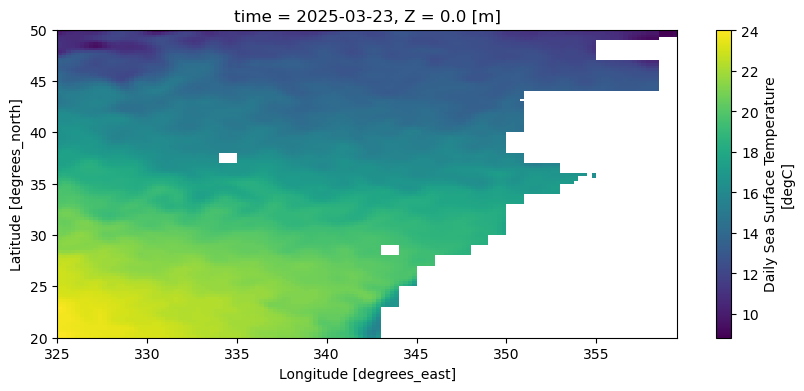

In [14]:
sst[-1,:,:].plot()

In [15]:
print('>>>>> '+titulo)

>>>>> Iberian Canary Basin


## Daily analisis

In [16]:
print('>>>>> Daily'+titulo+titulo_short)

>>>>> DailyIberian Canary BasinIBICan


In [ ]:
## Calculate mean weigthtened
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_weighted = sst.weighted(weights)
sst_wmean = sst_weighted.mean(("lon", "lat"),skipna=True).load()

In [ ]:
## Create monthly climatology
sst_clim = sst.sel(time=slice(yearC1,yearC2)).groupby('time.dayofyear').mean(dim='time').load();

In [ ]:
## Create anomaly
sst_anom = sst.groupby('time.dayofyear') - sst_clim

In [ ]:
## Calculate global mean anomaly
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_anom_weighted = sst_anom.weighted(weights)
sst_anom_wmean = sst_anom_weighted.mean(("lon", "lat"),skipna=True).load()

In [ ]:
## Save in netcdf
sst_wmean.to_netcdf(dataDir+'/sstd_mean_'+titulo_short+'.nc',mode='w')   
sst_anom_wmean.to_netcdf(dataDir+'/sstd_anom_mean_'+titulo_short+'.nc',mode='w')

In [ ]:
if titulo_short=='GO' or titulo_short=='NAtl' or titulo_short=='LEB' or titulo_short=='CAN' or titulo_short=='NOR' or titulo_short=='SUD' or titulo_short=='ESA' or titulo_short=='IBICan':
        sst_anom_LD=sst_anom[-1,:,:]
        sst_anom_LD.to_netcdf(dataDir+'/sstLD_anom_'+titulo_short+'.nc',mode='w')

# Monthly analisis

In [ ]:
sst = sst.resample(time='ME').mean(dim='time',skipna=True).load()

In [ ]:
## Calculate global mean weigthtened
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_weighted = sst.weighted(weights)
sst_wmean = sst_weighted.mean(("lon", "lat"),skipna=True).load()
    

In [ ]:
## Create monthly climatology
sst_clim = sst.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time').load();

In [ ]:
## Create anomaly
print('    > Compute anomaly mean')
sst_anom = sst.groupby('time.month') - sst_clim
sst_anom.load();

In [ ]:
##Calculate global mean weigthtened
print('    > Compute weigthtened mean')
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_anom_weighted = sst_anom.weighted(weights)
sst_anom_wmean = sst_anom_weighted.mean(("lon", "lat"),skipna=True).load()
sst_anom_wmean_rolling = sst_anom_wmean.rolling(time=12,center=True).mean()

In [ ]:
##Save in netcdf
print('    > to netcdf')
sst_anom.to_netcdf(dataDir+'/sstm_anom_'+titulo_short+'.nc',mode='w')
sst_wmean.to_netcdf(dataDir+'/sstm_mean_'+titulo_short+'.nc',mode='w')
sst_anom_wmean.to_netcdf(dataDir+'/sstm_anom_mean_'+titulo_short+'.nc',mode='w')